In [1]:
# DOWNLOADING Dataset from kaggle
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

100% 734M/736M [00:04<00:00, 106MB/s] 
100% 736M/736M [00:04<00:00, 178MB/s]


In [6]:
#Unzipping dataset
!unzip /content/eye-diseases-classification.zip

Archive:  /content/eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/catara

In [7]:
#import libraries
import os
import time
import shutil
import itertools
from pathlib import Path

#import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report, f1_score

#import DL libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [8]:
#Dataset Loading , Dataframe creation and dataset splitting
class EyeDiseaseDataset:
  def __init__(self,dataDir):
    self.data_dir = dataDir

  def dataPaths(self):
    filepaths = []
    labels = []

    folds = os.listdir(self.data_dir)
    for fold in folds:
      foldPath = os.path.join(self.data_dir,fold)
      filelist = os.listdir(foldPath)
      for file in filelist:
        fpath = os.path.join(foldPath,file)
        filepaths.append(fpath)
        labels.append(fold)
    return filepaths,labels

  def dataFrame(self,files,labels):
    Fseries = pd.Series(files, name = 'filepaths')
    Lseries = pd.Series(labels, name = 'labels')
    return pd.concat([Fseries,Lseries],axis=1)

  def split(self):
    files,labels = self.dataPaths()
    df = self.dataFrame(files,labels)
    strat = df['labels']
    trainData, dummyData = train_test_split(df,train_size=0.8, shuffle = True, random_state=42,stratify =strat)

    strat = dummyData['labels']
    validData,  testData = train_test_split(dummyData, train_size=0.5, shuffle= True,random_state = 42,stratify=strat)
    return trainData, validData, testData

In [9]:
dataDir = '/content/dataset'
dataSplit = EyeDiseaseDataset(dataDir)

In [10]:
train_data, valid_data, test_data = dataSplit.split()

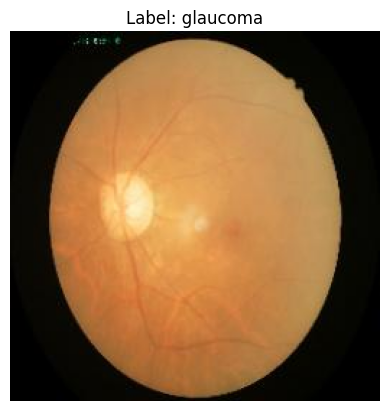

In [11]:
#Checking if data loading is correctly done
def display_random_image(df):
  random_row =df.sample(1).iloc[0]
  filepath = random_row['filepaths']
  label = random_row['labels']

  img = Image.open(filepath)
  plt.imshow(img)
  plt.title(f'Label: {label}')
  plt.axis('off')
  plt.show()

display_random_image(train_data)

In [12]:
#Data Augmentation
def augment_data(train_df, valid_df, test_df, batch_size=32):
  img_size = (256,256)
  channels= 3
  color = 'rgb'

  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=30,
      horizontal_flip =True,
      vertical_flip = True,
      brightness_range = [0.5,1.5])

  valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

  train_generator = train_datagen.flow_from_dataframe(
      train_df,
      x_col = 'filepaths',
      y_col = 'labels',
      target_size = img_size,
      color_mode = color,
      batch_size = batch_size,
      shuffle =True,
      class_mode = 'categorical')

  print("Shape of augmented training images", train_generator.image_shape)

  valid_generator = valid_test_datagen.flow_from_dataframe(
      valid_df,
      x_col = 'filepaths',
      y_col = 'labels',
      target_size = img_size,
      color_mode = color,
      batch_size = batch_size,
      shuffle =True,
      class_mode = 'categorical')

  print("Shape of augmented validation images", valid_generator.image_shape)

  test_generator = valid_test_datagen.flow_from_dataframe(
      test_df,
      x_col = 'filepaths',
      y_col = 'labels',
      target_size = img_size,
      color_mode = color,
      batch_size = batch_size,
      shuffle =False,
      class_mode = 'categorical')

  print("Shape of augmented test images", test_generator.image_shape)
  return train_generator, valid_generator , test_generator


In [13]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of augmented validation images (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of augmented test images (256, 256, 3)


In [14]:
type(train_augmented)

keras.src.preprocessing.image.DataFrameIterator

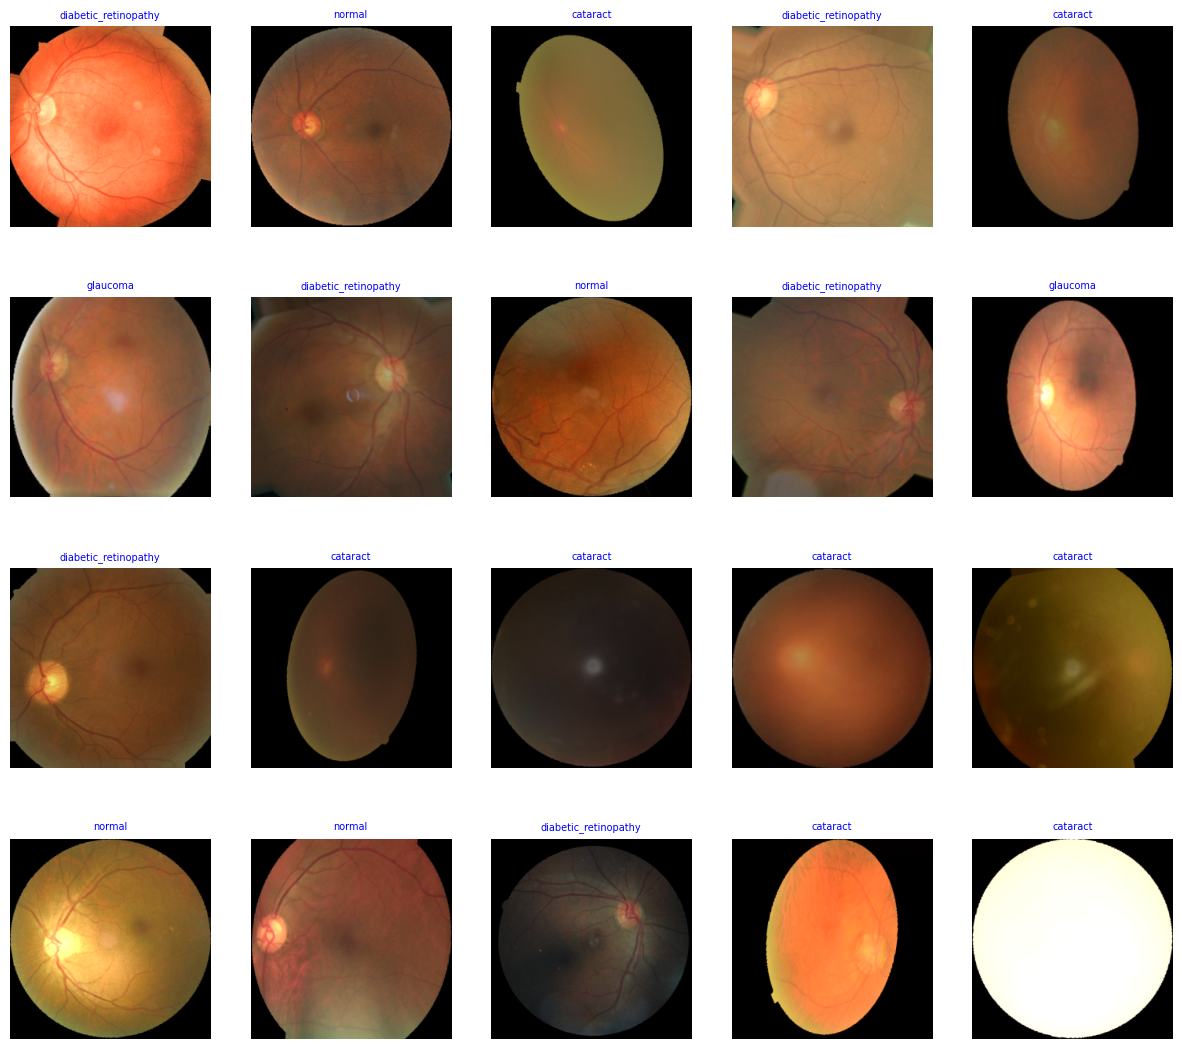

In [15]:
#Display images:

def show_images(gen):
  g_dict = gen.class_indices              #defines dictionary{'class':indices}
  classes = list(g_dict.keys())           #define list of dictionary keys
  images,labels = next(gen)               #gets batch size samples from generator

  length = len(labels)
  sample = min(length,20)

  plt.figure(figsize=(15,17))

  for i in range(sample):
    plt.subplot(5,5,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=7)
    plt.axis('off')
  plt.show()

show_images(train_augmented)

In [16]:
from tensorflow.keras.applications import EfficientNetB3

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

predictions = Dense(classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 0s 0us/step


In [17]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [18]:
history = model.fit(
    train_augmented,
    epochs=25, #you can train the model for more epochs
    validation_data=valid_augmented,
    )

Epoch 1/25
106/106 [==============================] - 101s 817ms/step - loss: 0.6120 - accuracy: 0.7507 - val_loss: 0.6428 - val_accuracy: 0.7299
Epoch 2/25
106/106 [==============================] - 79s 748ms/step - loss: 0.4344 - accuracy: 0.8298 - val_loss: 0.4584 - val_accuracy: 0.8341
Epoch 3/25
106/106 [==============================] - 79s 745ms/step - loss: 0.4092 - accuracy: 0.8358 - val_loss: 0.4212 - val_accuracy: 0.8436
Epoch 4/25
106/106 [==============================] - 82s 769ms/step - loss: 0.3425 - accuracy: 0.8687 - val_loss: 0.4493 - val_accuracy: 0.8318
Epoch 5/25
106/106 [==============================] - 78s 733ms/step - loss: 0.3430 - accuracy: 0.8648 - val_loss: 0.4378 - val_accuracy: 0.8412
Epoch 6/25
106/106 [==============================] - 81s 759ms/step - loss: 0.3140 - accuracy: 0.8790 - val_loss: 0.4456 - val_accuracy: 0.8223
Epoch 7/25
106/106 [==============================] - 80s 756ms/step - loss: 0.2883 - accuracy: 0.8838 - val_loss: 0.4044 - val_a

Training Accuracy: 0.9306255578994751
Validation Accuracy: 0.8886256217956543


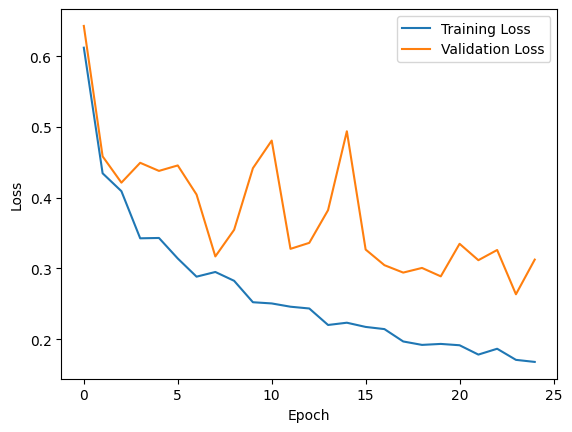

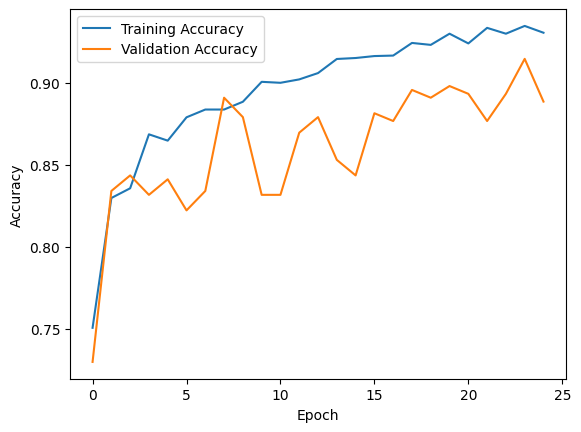

In [19]:
def plot_loss_accuracy(train_accuracy,val_accuracy,val_loss,loss):
  print("Training Accuracy:", train_accuracy[-1])
  print("Validation Accuracy:", val_accuracy[-1])
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
loss = history.history['loss']
plot_loss_accuracy(train_accuracy,val_accuracy,val_loss,loss)

1/1 [==============================] - 3s 3s/step


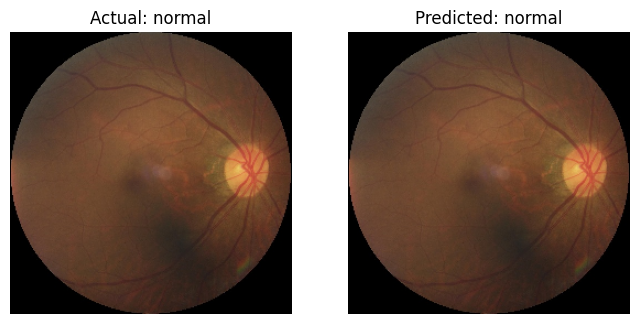

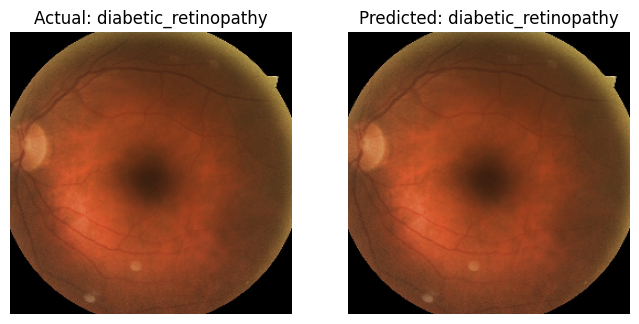

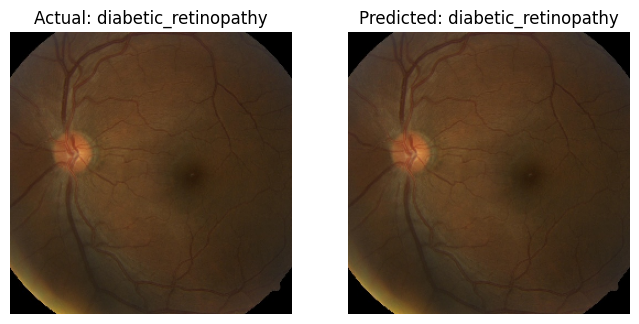

In [21]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    # Get a batch of test data
  test_images, test_labels = next(iter(test_data))

  predictions = model.predict(test_images)

  class_labels = list(train_augmented.class_indices.keys())

  sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
  for i in sample_indices:
    actual_label = class_labels[np.argmax(test_labels[i])]
    predicted_label = class_labels[np.argmax(predictions[i])]
    plt.figure(figsize=(8, 4))
    # Actual Image
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].astype(np.uint8))
    plt.title(f'Actual: {actual_label}')
    plt.axis('off')
    # Predicted Image
    plt.subplot(1, 2, 2)
    plt.imshow(test_images[i].astype(np.uint8))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

plot_actual_vs_predicted(model, test_augmented)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0][0]']   